# Diffusion code example

This example provides a short illustration of how to use Numba with the CPU parallel and CUDA targets.

The example function is very simple:
* We begin with a Gaussian hump of tracer.
* A finite-difference kernel diffuses the tracer over many iterations.

### Imports

In [1]:
from numba import cuda, njit, prange
import numpy as np
import pylab
from time import perf_counter

In [2]:
%matplotlib inline

### Run parameters

These are chosen for relatively quick execution, but with large enough data to make efficient use of CUDA.
* 10,000 iterations.
* A grid of 1,000 by 1,000 points.

In [3]:
ITERATIONS = 20000
POINTS = 1000

### Generation of initial conditions

* Creates a hump of tracer.
* We use Numba's `@njit` decorator to speed this up
  - Compiles the Python to native code.
  - Single-threaded.

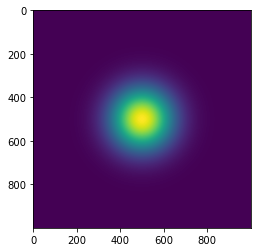

In [4]:
@njit
def gauss2d(x, y): 
    grid = np.empty_like(x)

    a = 1.0 / np.sqrt(2 * np.pi)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid[i, j] = a * np.exp(-(x[i, j]**2 / 2 + y[i, j]**2
                                      / 2)) 

    return grid


X = np.linspace(-5, 5, POINTS)
Y = np.linspace(-5, 5, POINTS)
x, y = np.meshgrid(X, Y)

z = gauss2d(x, y)

pylab.imshow(z)
pylab.show()

## Python version

We don't actually run this, because it will take too long.

Having the function definition here illustrates our starting point.

In [5]:
def smooth(x0, x1):
    for i in range(1, x0.shape[0] - 1): 
        for j in range(1, x0.shape[1] - 1): 
            x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                               x0[i - 1, j] + x0[i + 1, j]) 

def run_python():
    z0 = z.copy()
    z1 = np.zeros_like(z0)
    
    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth(z0, z1)
        else:
            smooth(z1, z0)

    end = perf_counter()

    time_python = end - start
    return z0, time_python


# Not running because it will take too long!
# z_python, time_python = run_python()
# pylab.imshow(z_python)
# pylab.show()

## CPU JIT

We parallelise execution on the CPU, for better performance:
* Passing `parallel=True` to the `@njit` decorator
* Using a `prange` instead of a `range` to indicate how to parallelize.

Benchmarking the CPU implementation requires a little care:

* The first call to the `smooth_jit()` function will trigger JIT compilation of the function which is quite costly in comparison to an iteration (a few hundred milliseconds, perhaps)
  * So, we make a "dummy call" before starting our timed loop, so the JIT compilation is out of the way.

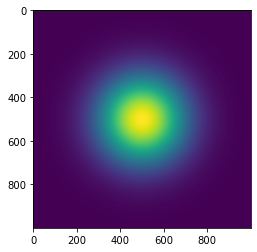

In [6]:
@njit(parallel=True)
def smooth_jit(x0, x1):
    for i in prange(1, x0.shape[0] - 1): 
        for j in range(1, x0.shape[1] - 1): 
            x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                               x0[i - 1, j] + x0[i + 1, j]) 


def run_cpu_jit():
    z0 = z.copy()
    z1 = np.zeros_like(z0)

    # Warm up JIT
    smooth_jit(z0, z1) 

    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth_jit(z0, z1) 
        else:
            smooth_jit(z1, z0) 

    end = perf_counter()


    time_cpu = end - start
    return z0, time_cpu

z_cpu, time_cpu = run_cpu_jit()

pylab.imshow(z_cpu)
pylab.show()

## CUDA JIT

Parallel implementation on the CPU requires some more changes:

* Use of the `@cuda.jit` decorator.
* The `for` loops are "flattended" - `smooth_cuda()` is invoked by many threads.
  - Each thread gets its index `(i, j)` from `cuda.grid(2)` (for a 2D grid).
  - We check this kernel's indices are in the bounds
    - (the interior of the domain)
* The number of threads to launch (the grid and block dimensions) are computed.
  - We use a fixed size block here, and work out how many we need based on the input size.
  - We could also use a loop inside the `smooth_cuda` function (a *grid-stride loop*) but don't here for simplicity.
  
Benchmarking the CUDA implementation needs a little more care:

* We copy data over to the device first.
  * If we don't do this, we end up creating implicit copies every time the kernel is launched.
  * Implicit copies insert a lot of synchronization points and slow down execution considerably.
* We call `cuda.synchronize()` before ending timing.
  * Kernel launches are asynchronous, so if we don't do this the GPU still can have work to do when we stop the timer.

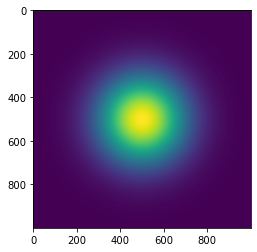

In [7]:
@cuda.jit
def smooth_cuda(x0, x1):
    i, j = cuda.grid(2)

    i_in_bounds = (i > 0) and (i < (x0.shape[0] - 1))
    j_in_bounds = (j > 0) and (j < (x0.shape[1] - 1))

    if i_in_bounds and j_in_bounds:
        x1[i, j] = 0.25 * (x0[i, j - 1] + x0[i, j + 1] +
                           x0[i - 1, j] + x0[i + 1, j])


def run_cuda_jit():
    # Copy to device
    z0 = cuda.to_device(z)
    z1 = cuda.device_array_like(np.zeros_like(z))

    # Warm up JIT
    blockdim = (16, 16)
    griddim = ((z0.shape[0] // blockdim[0]) + 1, (z0.shape[1] // blockdim[1]) + 1)
    smooth_cuda[griddim, blockdim](z0, z1)

    start = perf_counter()

    for i in range(ITERATIONS):
        if (i % 2) == 0:
            smooth_cuda[griddim, blockdim](z0, z1)
        else:
            smooth_cuda[griddim, blockdim](z1, z0)

    # Make sure the GPU is finished before we stop timing
    cuda.synchronize()
    end = perf_counter()

    
    time_cuda = end - start
    return z0.copy_to_host(), time_cuda

z_cuda, time_cuda = run_cuda_jit()

pylab.imshow(z_cuda)
pylab.show()

## Check and compare results

Hopefully the difference between the solutions (CPU and CUDA) should look fairly small:

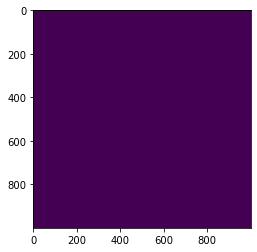

In [8]:
diff = np.abs(z_cpu - z_cuda)
pylab.imshow(diff)
pylab.show()

## Compare performance

Before giving any performance measurements, it's always a good idea to (somewhat) rigorously check correctness:

In [9]:
# Ensure the solutions are reasonably close
np.testing.assert_allclose(z_cpu, z_cuda)

# If so, print out execution times
print(f"CPU time: {time_cpu:2.2f} seconds")
print(f"CUDA time: {time_cuda:2.2f} seconds")

CPU time: 10.23 seconds
CUDA time: 1.37 seconds
